# Image Segmentaion using U-Nets

In [145]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import random


In [190]:
random.seed(42)

In [152]:
img_width = 128
img_height = 128
img_channels = 3

In [217]:
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'


In [218]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [234]:
X_train = np.zeros((len(train_ids),img_height,img_width,img_channels),dtype=np.uint8)
Y_train = np.zeros((len(train_ids),img_height,img_width,1),dtype=np.bool_)
X_test = np.zeros((len(test_ids),img_height,img_width,img_channels),dtype=np.uint8)
print(X_test.shape)
print(X_train.shape)
print(Y_train.shape)

(65, 128, 128, 3)
(670, 128, 128, 3)
(670, 128, 128, 1)


#### Resize Train images

In [237]:
print('Resizing the images')

for n,id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((img_height,img_width,1),dtype=np.bool_)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode='constant',preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   
                  

  0%|                                                                                          | 0/670 [00:00<?, ?it/s]

Resizing the images


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [08:53<00:00,  1.26it/s]


In [238]:

for n,id_ in tqdm(enumerate(test_ids),total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    X_test[n] = img
#     mask = np.zeros((img_height,img_width,1),dtype=np.bool_)

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 22.25it/s]


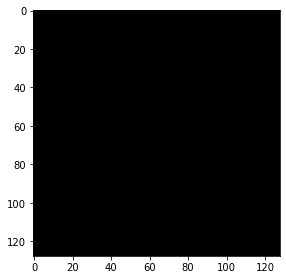

In [228]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
#imshow(np.squeeze(Y_train[image_x]))
plt.show()


In [224]:
X_train.shape

(670, 128, 128, 3)

In [225]:
X_train[3].shape

(128, 128, 3)

In [226]:
X_test.shape

(65, 128, 128, 3)

#### Build Model

In [239]:
inputs = layers.Input((img_width,img_height,img_channels))
s = tf.keras.layers.Lambda(lambda x : x/255)(inputs)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = layers.Dropout(0.1)(c1)
#print(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
#print(c1)
p1 =  layers.MaxPooling2D((2,2))(c1)
#print(p1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
print('C5',c5)
#Expasive

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
print('CONV2D TRANSPOSE',u6)
u6 = tf.keras.layers.concatenate([u6, c4])
print('TRANSPOSE',u6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


C5 Tensor("conv2d_313/Identity:0", shape=(None, 8, 8, 256), dtype=float32)
CONV2D TRANSPOSE Tensor("conv2d_transpose_71/Identity:0", shape=(None, 16, 16, 128), dtype=float32)
TRANSPOSE Tensor("concatenate_57/Identity:0", shape=(None, 16, 16, 256), dtype=float32)
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_19 (Lambda)              (None, 128, 128, 3)  0           input_24[0][0]                   
__________________________________________________________________________________________________
conv2d_304 (Conv2D)             (None, 128, 128, 16) 448         lambda_19[0][0]                  
__________________________

In [240]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5',verbose=1,save_best_only=True)

callbacks = [
    keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
    keras.callbacks.TensorBoard(log_dir='logs')
]

results = model.fit(X_train,Y_train,validation_split=0.1, batch_size =16,epochs=10,callbacks=callbacks)

Epoch 1/10
38/38 [==============================] - 62s 2s/step - loss: 0.5067 - accuracy: 0.7870 - val_loss: 0.2867 - val_accuracy: 0.8162
Epoch 2/10
38/38 [==============================] - 56s 1s/step - loss: 0.2995 - accuracy: 0.7985 - val_loss: 0.2339 - val_accuracy: 0.8216
Epoch 3/10
38/38 [==============================] - 56s 1s/step - loss: 0.2302 - accuracy: 0.8923 - val_loss: 0.1779 - val_accuracy: 0.9263
Epoch 4/10
38/38 [==============================] - 57s 1s/step - loss: 0.1717 - accuracy: 0.9351 - val_loss: 0.1221 - val_accuracy: 0.9508
Epoch 5/10
38/38 [==============================] - 56s 1s/step - loss: 0.1297 - accuracy: 0.9504 - val_loss: 0.1179 - val_accuracy: 0.9546
Epoch 6/10
38/38 [==============================] - 57s 1s/step - loss: 0.1184 - accuracy: 0.9552 - val_loss: 0.1110 - val_accuracy: 0.9579
Epoch 7/10
38/38 [==============================] - 56s 1s/step - loss: 0.1070 - accuracy: 0.9590 - val_loss: 0.1058 - val_accuracy: 0.9613
Epoch 8/10
38/38 [==

In [241]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


3/3 [==============================] - 1s 204ms/step


In [183]:
np.squeeze(Y_train[1])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

223


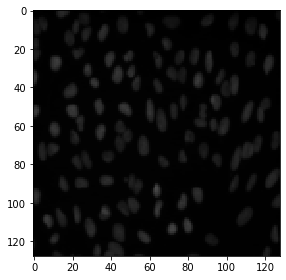

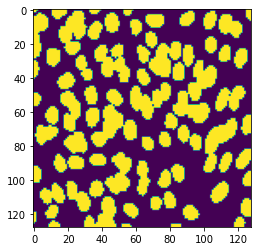

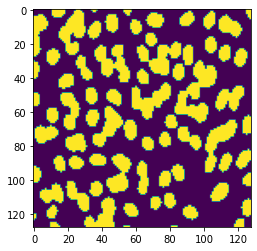

In [242]:
ix = random.randint(0, len(preds_train_t))
print(ix)
imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix]))
plt.show()
plt.imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# # Perform a sanity check on some random validation samples
# ix = random.randint(0, len(preds_val_t))
# imshow(X_train[int(X_train.shape[0]*0.9):][ix])
# plt.show()
# imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
# plt.show()
# imshow(np.squeeze(preds_val_t[ix]))
# plt.show()

In [244]:
X_test

array([[[[  1,   1,   1],
         [  2,   2,   2],
         [  2,   2,   2],
         ...,
         [  2,   2,   2],
         [  2,   2,   2],
         [  1,   1,   1]],

        [[  2,   2,   2],
         [  2,   2,   2],
         [  3,   3,   3],
         ...,
         [  2,   2,   2],
         [  1,   1,   1],
         [  2,   2,   2]],

        [[  1,   1,   1],
         [  2,   2,   2],
         [  3,   3,   3],
         ...,
         [  2,   2,   2],
         [  2,   2,   2],
         [  2,   2,   2]],

        ...,

        [[  2,   2,   2],
         [  2,   2,   2],
         [  2,   2,   2],
         ...,
         [  2,   2,   2],
         [  3,   3,   3],
         [  2,   2,   2]],

        [[  2,   2,   2],
         [  2,   2,   2],
         [  2,   2,   2],
         ...,
         [  2,   2,   2],
         [  2,   2,   2],
         [  2,   2,   2]],

        [[  1,   1,   1],
         [  2,   2,   2],
         [  2,   2,   2],
         ...,
         [  2,   2,   2],
        

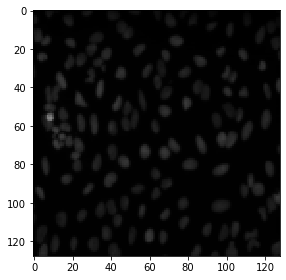

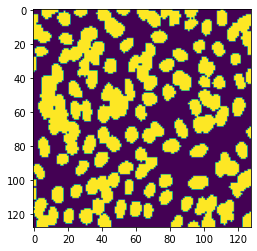

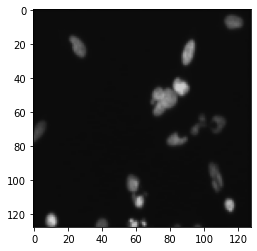

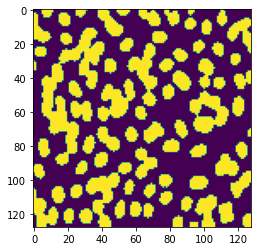

In [246]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
plt.imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
plt.imshow(X_test[int(X_test.shape[0]*0.9):][ix])
plt.show()
plt.imshow(np.squeeze(preds_val_t[ix]))
plt.show()